In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device    = 'cpu'
print('the device is %s' % device)


sys.path.insert(0, "../Marilyn_train/data_train/model_utils/")
import myTrainPrep

from models.myEval import myPerform2

pd.set_option('display.max_columns', None)

the device is cuda


In [2]:
shuffle_seed      = 37
pos_size          = 250
neg_size          = 270
train_size        = 1000
BATCHSIZE        = 500

num_epochs = 2000
prefix     = "20210321-CNN3-net8-EVS-1000"
title_name = "%s_train_size%s_batch_size%s" % (prefix, train_size, BATCHSIZE)
print(title_name)

20210321-CNN3-net8-EVS-1000_train_size1000_batch_size500


In [3]:


label_feature = pd.read_csv("../Marilyn_train/data_process/Marilyn-std0.02/labeled.csv").values
label_target  = pd.read_csv("../Marilyn_train/data_process/Marilyn-std0.02/true_label.csv").values.reshape(-1)

pos_feature = label_feature[label_target == 1]
pos_label   = label_target[label_target == 1]
np.random.seed(shuffle_seed)
np.random.shuffle(pos_feature)
np.random.seed(shuffle_seed)
np.random.shuffle(pos_label)

neg_feature = label_feature[label_target == 0]
neg_label   = label_target[label_target == 0]
np.random.seed(shuffle_seed)
np.random.shuffle(neg_feature)
np.random.seed(shuffle_seed)
np.random.shuffle(neg_label)

train_x = np.array(list(pos_feature[0:pos_size]) +list(neg_feature[0:neg_size]))
train_y = np.array(list(pos_label[0:pos_size]) + list(neg_label[0:neg_size]))
valid_x = np.array(list(pos_feature[pos_size:]) + list(neg_feature[neg_size:]))
valid_y = np.array(list(pos_label[pos_size:]) + list(neg_label[neg_size:]))

trainDataset = TensorDataset(torch.Tensor(label_feature[:, np.newaxis, :]), torch.Tensor(label_target).long())
labeledLoader = DataLoader(dataset=trainDataset, batch_size = BATCHSIZE, shuffle=True)

validDataset = TensorDataset(torch.Tensor(valid_x[:, np.newaxis, :]), torch.Tensor(valid_y).long())
validLoader  = DataLoader(dataset=validDataset, batch_size = BATCHSIZE, shuffle=False)

In [4]:
unlabel_data  = pd.read_csv("../Marilyn_train/data_process/Marilyn-std0.02/unlabel.csv").sample(n=60_000, replace=False, axis=0, random_state=1).values
unlabeledDataset = TensorDataset(torch.Tensor(unlabel_data[:, np.newaxis, :]))
unlabeledLoader  = DataLoader(dataset=unlabeledDataset, batch_size=BATCHSIZE, shuffle=True)

In [5]:
from models.model_20210222_CNN3 import model3_1
from ssl_models.myGen import NetG8
modelCD     = model3_1().to(device)
modelG      = NetG8().to(device)
criterionC  = nn.CrossEntropyLoss()
optimizerCD = optim.Adam(modelCD.parameters(), lr=0.00095, betas=(0.5, 0.999), weight_decay = .01)
optimizerG  = optim.Adam(modelG.parameters(),  lr=0.00095, betas=(0.5, 0.999), weight_decay = .01)

In [6]:
print(modelCD)
print(modelG)

CNN1d_5layer(
  (cnn1): Sequential(
    (0): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv1d(10, 40, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv1d(40, 200, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=13000, out_features=2, bias=True)
  )
)
NetG8(
  (Linear1): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.6, inplace=False)
  )
  (lin

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(comment="%s" % prefix)

maxacc = 0


global_step = 1
iter_labeled = iter(labeledLoader)


for epoch in tqdm.tqdm(range(num_epochs)):
    for step, x_unlabeled in enumerate(unlabeledLoader):

        #################################################################################  Classifier/Discriminator 
        modelCD.train()
        modelG.eval()
        
        optimizerCD.zero_grad()
        
        ## label
        try:
            x_labeled, y_labeled = next(iter_labeled)
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
        except StopIteration:
            iter_labeled = iter(labeledLoader)
            x_labeled, y_labeled = next(iter_labeled)
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
        
        
        _, outClassLabeled  = modelCD(x_labeled)
        lossLabeled      = criterionC(outClassLabeled, y_labeled)
        
        
        ## unlabel
        x_unlabeled = x_unlabeled[0].to(device)
        _, outClassUnlabeled  = modelCD(x_unlabeled)
        
        logz_unlabeled = torch.logsumexp(outClassUnlabeled, dim=1)
        lossUnlabeled  = -0.5 * torch.mean(logz_unlabeled) + 0.5 * torch.mean(F.softplus(logz_unlabeled))
        
        ## Fake
        fakeNoise1       = torch.randn(x_unlabeled.size(0), 30, device=device)
        x_Fake1          = ( modelG(fakeNoise1) + 1.0 ) / 2
        _, outClassFake1 = modelCD(x_Fake1)

        logz_fake1 = torch.logsumexp(outClassFake1, dim=1)
        lossFake  = 0.5 * torch.mean(F.softplus(logz_fake1))
        

        ## loss
        totalLoss = lossLabeled + lossUnlabeled + lossFake
        
        ## optimization
        writer.add_scalar("training_loss/supervised", lossLabeled, global_step)
        writer.add_scalar("training_loss/unsupervised", lossUnlabeled+lossFake, global_step)
        writer.add_scalar("training_loss/D_Loss", totalLoss, global_step)

        totalLoss.backward()
        optimizerCD.step()
        
                
        #################################################################################  Generator
        modelCD.eval()
        modelG.train()
        optimizerG.zero_grad()
        
        fakeNoise2 = torch.randn(x_unlabeled.size(0), 30, device=device)
        x_Fake2    = ( modelG(fakeNoise2) + 1.0 ) / 2
        
        ## loss
        y_pred_unlabeled, _ = modelCD(x_unlabeled)
        y_pred_fake, _      = modelCD(x_Fake2)
        mom_real = torch.mean(y_pred_unlabeled, dim=0)
        mom_fake = torch.mean(y_pred_fake, dim=0)
        diff = mom_fake * 100 - mom_real * 100
        lossG = torch.mean(diff * diff)
        
        
        ## optimization
        writer.add_scalar("training_loss/G_loss", lossG, global_step)
        lossG.backward()        
        optimizerG.step()

        global_step += 1
  
    
    
    train_loss, train_accuracy = myPerform2(modelCD, criterionC, device, labeledLoader, False)
    writer.add_scalar("accuracy/train", train_accuracy, epoch)

#     test_loss, test_accuracy = myPerform2(modelCD, criterionC, device, validLoader, False)
#     writer.add_scalar("accuracy/test", test_accuracy, epoch)
    
    
    if epoch >= 1000 and train_accuracy > maxacc:
        torch.save(modelCD.state_dict(), './model_save/%s_%s.pt' % (title_name, epoch))
        maxacc = train_accuracy


    
writer.flush()
writer.close()

 32%|███▏      | 631/2000 [1:19:05<2:50:56,  7.49s/it]

In [ ]:
torch.save(modelCD.state_dict(), './model_save/%s.pt' % title_name)

### 

# 6k prediction

In [9]:
# from models.model_20210222_CNN3 import model3_1
# modelCD     = model3_1().to(device)
# modelCD.load_state_dict(torch.load('./model_save/20210319-CNN3-net8_train_size4000_batch_size500_1368.pt'))

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score 
import math
import matplotlib.pyplot as plt

def myEval(model, device, test_loader, display = False):
    model.eval()
    
    target_list = []
    output_list = []
    
    with torch.no_grad():
        for testdata in test_loader:
            data, target = testdata
            data, target = data.to(device), target.to(device)
            _, output = model(data)
            softmax2_score = [ math.exp(i[1]) / ( math.exp(i[0]) + math.exp(i[1]) ) for i in output.cpu().numpy() ]
            target_list += target.cpu().tolist()
            output_list += softmax2_score

    return target_list, output_list


def evaluation_df(pred_score, labeled_y):
    def TP_table(pred_score, labeled_y, threshold):
        y_pred = [0 if i < threshold else 1 for i in pred_score]
        y_true = list(labeled_y)


        fpr, tpr, _ = roc_curve(y_true, pred_score)
        auc_val = auc(fpr, tpr)


        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # TP TN FP FN sensitivity specificity Accuracy
        sensitivity = tp/(tp+fn)

        specificity = tn/(tn+fp)
        accuracy    = (tp+tn)/(tp+tn+fp+fn)
        
        F1 = f1_score(y_true, y_pred)
        
        try:
            MCC = ((tp*tn)-(fp*fn)) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
        except:
            MCC = np.nan

        return [threshold, tp, fp, tn, fn, sensitivity, specificity, accuracy, auc_val, MCC, F1]

    res = []
    for i in range(1,20):
        threshold = i / 20
        res.append(TP_table(pred_score, labeled_y, threshold))

    res = pd.DataFrame(res, columns=['threshold', 'TP', 'FP', 'TN', 'FN', 'sen', 'spe', 'Acc', 'AUC', 'MCC', 'F1'])
    return res


In [11]:
label, pred = myEval(modelCD, device, validLoader)
evaluation_df(pred, label)

NameError: name 'validLoader' is not defined

In [12]:
pos_arr = np.array(pred)[np.array(label)==1]
neg_arr = np.array(pred)[np.array(label)==0]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(pos_arr, bins=100, label='pos', color='cornflowerblue')
plt.legend()
plt.subplot(1,2,2)
plt.hist(neg_arr, bins=100, label='neg', color='coral')
plt.legend()
plt.show()

NameError: name 'pred' is not defined

In [13]:
label_feature = pd.read_csv("../Marilyn_train/data_process/Test6k/labeled.csv").values
label_target  = pd.read_csv("../Marilyn_train/data_process/Test6k/true_label.csv").values.reshape(-1)


testDataset = TensorDataset(torch.Tensor(label_feature[:, np.newaxis, :]), torch.Tensor(label_target).long())
testLoader = DataLoader(dataset=testDataset, batch_size = BATCHSIZE, shuffle=True)

label, pred = myEval(modelCD, device, testLoader)
evaluation_df(pred, label)

,threshold,TP,FP,TN,FN,sen,spe,Acc,AUC,MCC,F1
0,0.05,1296,3766,1125,39,0.970787,0.230014,0.388853,0.827684,0.211382,0.405190
1,0.10,1282,3433,1458,53,0.960300,0.298099,0.440090,0.827684,0.247375,0.423802
2,0.15,1268,3231,1660,67,0.949813,0.339399,0.470286,0.827684,0.265125,0.434693
3,0.20,1255,3078,1813,80,0.940075,0.370681,0.492772,0.827684,0.277261,0.442837
4,0.25,1246,2933,1958,89,0.933333,0.400327,0.514616,0.827684,0.291507,0.451941
5,0.30,1238,2832,2059,97,0.927341,0.420977,0.529553,0.827684,0.300465,0.458094
6,0.35,1226,2726,2165,109,0.918352,0.442650,0.544651,0.827684,0.307713,0.463779
7,0.40,1217,2620,2271,118,0.911610,0.464322,0.560231,0.827684,0.317282,0.470611
8,0.45,1196,2507,2384,139,0.895880,0.487426,0.575008,0.827684,0.320442,0.474792
9,0.50,1182,2398,2493,153,0.885393,0.509712,0.590267,0.827684,0.328031,0.480977


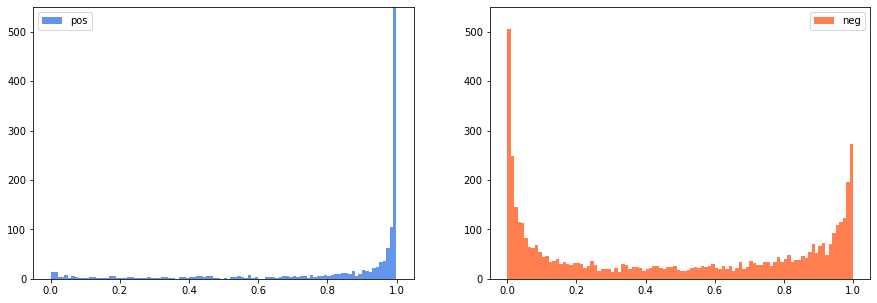

In [14]:
pos_arr = np.array(pred)[np.array(label)==1]
neg_arr = np.array(pred)[np.array(label)==0]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(pos_arr, bins=100, label='pos', color='cornflowerblue')
plt.ylim(0,550)
plt.legend()
plt.subplot(1,2,2)
plt.hist(neg_arr, bins=100, label='neg', color='coral')
plt.ylim(0,550)
plt.legend()
plt.show()

#
#
#

## other datasets prediciton

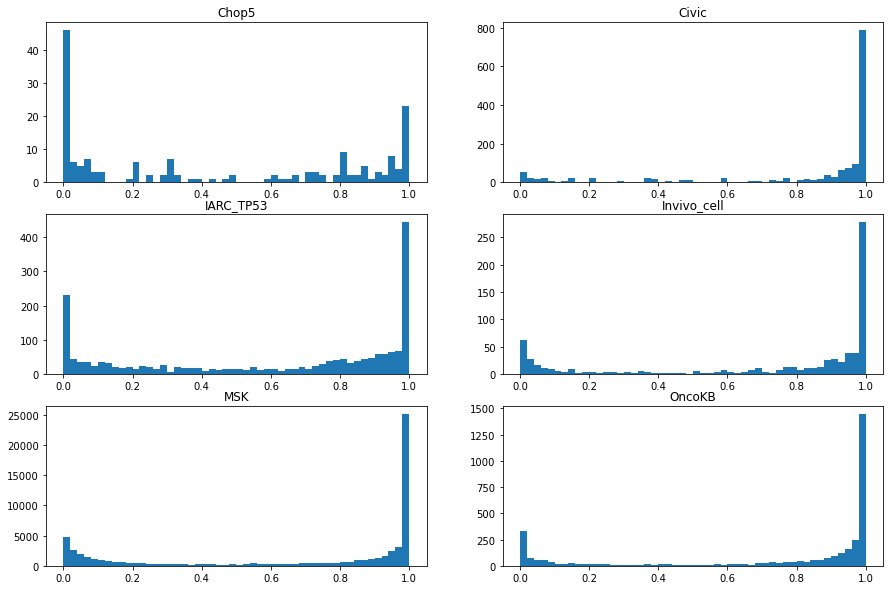

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))


for ind, path in enumerate(["../Marilyn_train/data_process/Chop5/labeled.csv", 
             "../Marilyn_train/data_process/Civic/labeled.csv", 
             "../Marilyn_train/data_process/IARC_TP53/labeled.csv", 
             "../Marilyn_train/data_process/Invivo_cell/labeled.csv",
             "../Marilyn_train/data_process/MSK/labeled.csv", 
             "../Marilyn_train/data_process/OncoKB/labeled.csv"]):
    
# for ind, path in enumerate(["../Marilyn_train/data_process/MSK/labeled.csv", 
#              "../Marilyn_train/data_process/OncoKB/labeled.csv"]):

    plt.subplot(3,2,ind+1)
    label_feature = pd.read_csv(path).values
    label_target  = np.ones( label_feature.shape[0] )
    testDataset = TensorDataset(torch.Tensor(label_feature[:, np.newaxis, :]), torch.Tensor(label_target).long())
    testLoader = DataLoader(dataset=testDataset, batch_size = BATCHSIZE, shuffle=True)

    label, pred = myEval(modelCD, device, testLoader)

    
#     raw_dat = pd.read_csv(path.replace("labeled.csv", "filtered_dat.csv"))
#     raw_dat['pred_score'] = pred
#     raw_dat.to_csv(path.replace("labeled.csv", "%s.mod3_pred.csv" % path.split("/")[3]), index=False)
    
    plt.hist(pred, bins=50)
    plt.title(path.split("/")[3])
    
plt.show()